### Preview Environment Data

In [1]:
# System operations
import inspect
import os
import uuid

# Date and time
from datetime import datetime

# type hinting
from typing import List, Mapping, Tuple

# Data visualization
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# User interaction
from IPython.display import clear_output
from ipywidgets import Button, FloatSlider, HBox, HTML
from ipywidgets import IntProgress, Text, VBox

# Data manipulation
from bs4 import BeautifulSoup
import math
import numpy as np
import pandas as pd
import random
import re
import requests
import simplejson as json

# CityLearn
from citylearn.agents.rbc import HourRBC
from citylearn.agents.q_learning import TabularQLearning
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import TabularQLearningWrapper

# baseline RL algorithms
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback

2025-04-08 14:47:44.689836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744138064.712306  456141 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744138064.719258  456141 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744138064.738220  456141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744138064.738238  456141 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744138064.738241  456141 computation_placer.cc:177] computation placer alr

Here we include some global settings we want applied for the remainder of the notebook:

In [2]:
# set all plotted figures without margins
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

In [3]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
ds = DataSet()
schema = ds.get_schema(DATASET_NAME)

### Preview a Building Data File
We can now preview the data files for one of the buildings in the `citylearn_challenge_2022_phase_all` dataset. The schema includes a `root_directory` key-value where all files that are relevant to this dataset are stored as well as the name of each file. We will use this root directory and filenames to read a building file:

In [4]:
root_directory = schema['root_directory']

# change the suffix number in the next code line to a
# number between 1 and 17 to preview other buildings
building_name = 'Building_1'

filename = schema['buildings'][building_name]['energy_simulation']
filepath = os.path.join(root_directory, filename)
building_data = pd.read_csv(filepath)
display(building_data.head())

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
0,7,24,7,0,NaN,NaN,NaN,2.275800,0.0,0.0,0.0,0.0
1,8,1,1,0,NaN,NaN,NaN,0.851167,0.0,0.0,0.0,0.0
2,8,2,1,0,NaN,NaN,NaN,0.834600,0.0,0.0,0.0,0.0
3,8,3,1,0,NaN,NaN,NaN,0.838167,0.0,0.0,0.0,0.0
4,8,4,1,0,NaN,NaN,NaN,1.478433,0.0,0.0,0.0,0.0


This building file has 12 fields describing the hourly building loads and indoor environmental conditions. Descriptive statistics of these fields are reported below:

In [5]:
display(building_data.describe(include='all'))

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,heating_demand,solar_generation
count,8760.000000,8760.000000,8760.000000,8760.0,0.0,0.0,0.0,8760.000000,8760.0,8760.0,8760.0,8760.000000
mean,6.526027,12.500000,3.992466,0.0,NaN,NaN,NaN,1.208145,0.0,0.0,0.0,205.836089
std,3.448048,6.922582,2.003522,0.0,NaN,NaN,NaN,0.968270,0.0,0.0,0.0,290.977786
min,1.000000,1.000000,1.000000,0.0,NaN,NaN,NaN,0.057000,0.0,0.0,0.0,0.000000
25%,4.000000,6.750000,2.000000,0.0,NaN,NaN,NaN,0.570167,0.0,0.0,0.0,0.000000
50%,7.000000,12.500000,4.000000,0.0,NaN,NaN,NaN,0.812079,0.0,0.0,0.0,0.000000
75%,10.000000,18.250000,6.000000,0.0,NaN,NaN,NaN,1.530529,0.0,0.0,0.0,412.108335
max,12.000000,24.000000,7.000000,0.0,NaN,NaN,NaN,7.987483,0.0,0.0,0.0,976.250000


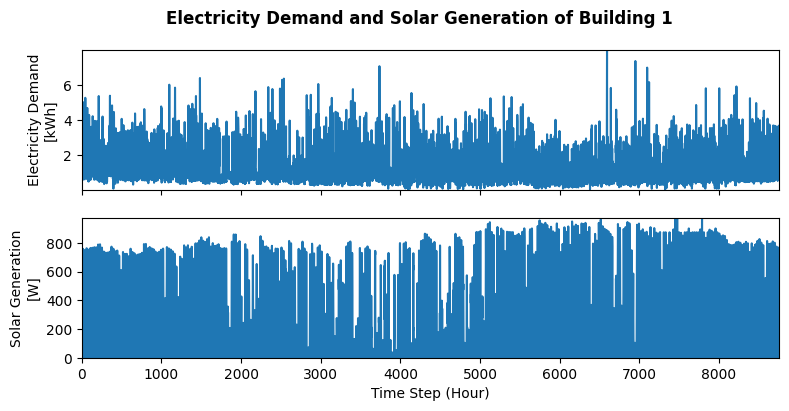

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(9, 4), sharex=True)
x = building_data.index
y1 = building_data['non_shiftable_load']
y2 = building_data['solar_generation']
axs[0].plot(x, y1)
# axs[0].set_xlabel('Time Step (Hour)')
axs[0].set_ylabel('Electricity Demand\n[kWh]')
axs[1].plot(x, y2)
axs[1].set_xlabel('Time Step (Hour)')
axs[1].set_ylabel('Solar Generation\n[W]')
fig.suptitle('Electricity Demand and Solar Generation of Building 1', fontweight='bold')
plt.savefig('preview_plots/building_1_demand_generation')
plt.show()

### Preview Weather File

Other supplemental data in the dataset include [TMY3 weather data from the Los Angeles International Airport weather station](https://energyplus.net/weather-location/north_and_central_america_wmo_region_4/USA/CA/USA_CA_Los.Angeles.Intl.AP.722950_TMY3) that is representative of a typical meteorological year in the Los Angeles International Airport location. All buildings in this dataset reference the same weather file as previewed:

In [7]:
filename = schema['buildings'][building_name]['weather']
filepath = os.path.join(root_directory, filename)
weather_data = pd.read_csv(filepath)
display(weather_data.head())

,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_1,outdoor_dry_bulb_temperature_predicted_2,outdoor_dry_bulb_temperature_predicted_3,outdoor_relative_humidity_predicted_1,outdoor_relative_humidity_predicted_2,outdoor_relative_humidity_predicted_3,diffuse_solar_irradiance_predicted_1,diffuse_solar_irradiance_predicted_2,diffuse_solar_irradiance_predicted_3,direct_solar_irradiance_predicted_1,direct_solar_irradiance_predicted_2,direct_solar_irradiance_predicted_3
0,20.0,84.0,0.0,0.0,18.3,22.8,20.0,81.0,68.0,81.0,25.0,964.0,0.0,100.0,815.0,0.0
1,20.1,79.0,0.0,0.0,19.4,22.8,19.4,79.0,71.0,87.0,201.0,966.0,0.0,444.0,747.0,0.0
2,19.7,78.0,0.0,0.0,21.1,22.2,19.4,73.0,73.0,87.0,420.0,683.0,0.0,592.0,291.0,0.0
3,19.3,78.0,0.0,0.0,22.2,22.8,19.4,71.0,71.0,90.0,554.0,522.0,0.0,491.0,153.0,0.0
4,18.9,78.0,0.0,0.0,21.7,22.2,18.9,73.0,71.0,90.0,778.0,444.0,0.0,734.0,174.0,0.0


The weather file has fields that describe the outdoor dry-bulb temperature, relative humidity, diffuse and direct solar radiation, as well as their 6 hour, 12 hour and 24 hour forecasts. In this dataset, the forecasts are perfect forecasts for example, the 6 hour outdoor dry-bulb temperature forecast at a certain time step is equal to the temperature 6 hours later. The summary statistics for the weather fields are provided below:

In [8]:
display(weather_data.describe(include='all'))

,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance,outdoor_dry_bulb_temperature_predicted_1,outdoor_dry_bulb_temperature_predicted_2,outdoor_dry_bulb_temperature_predicted_3,outdoor_relative_humidity_predicted_1,outdoor_relative_humidity_predicted_2,outdoor_relative_humidity_predicted_3,diffuse_solar_irradiance_predicted_1,diffuse_solar_irradiance_predicted_2,diffuse_solar_irradiance_predicted_3,direct_solar_irradiance_predicted_1,direct_solar_irradiance_predicted_2,direct_solar_irradiance_predicted_3
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,16.837454,73.004224,208.282192,201.231507,16.837454,16.837454,16.837454,73.004224,73.004224,73.004224,208.282192,208.282192,208.282192,201.231507,201.231507,201.231507
std,3.564816,16.480251,292.799407,296.193301,3.564816,3.564816,3.564816,16.480251,16.480251,16.480251,292.799407,292.799407,292.799407,296.193301,296.193301,296.193301
min,5.600000,10.000000,0.000000,0.000000,5.600000,5.600000,5.600000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.400000,65.000000,0.000000,0.000000,14.400000,14.400000,14.400000,65.000000,65.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17.200000,76.000000,10.000000,0.000000,17.200000,17.200000,17.200000,76.000000,76.000000,76.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000
75%,19.400000,84.000000,382.000000,424.000000,19.400000,19.400000,19.400000,84.000000,84.000000,84.000000,382.000000,382.000000,382.000000,424.000000,424.000000,424.000000
max,32.200000,100.000000,1017.000000,953.000000,32.200000,32.200000,32.200000,100.000000,100.000000,100.000000,1017.000000,1017.000000,1017.000000,953.000000,953.000000,953.000000


We can also plot this weather data on an axes to understand it better:

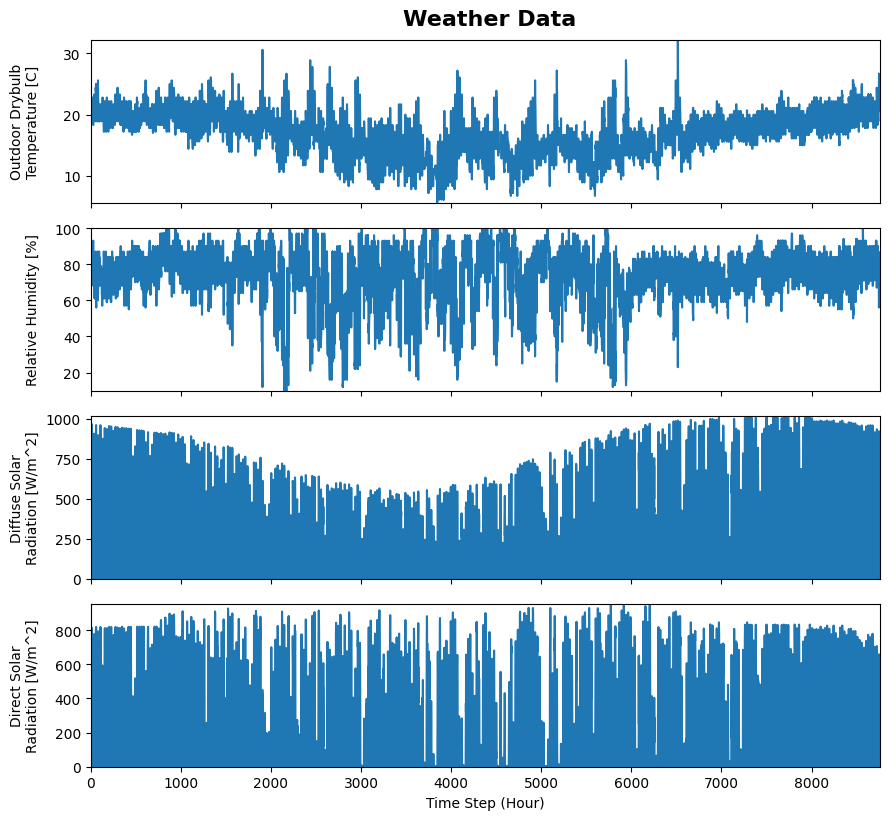

In [9]:
columns = [
    'Outdoor Drybulb\nTemperature [C]', 'Relative Humidity [%]',
    'Diffuse Solar\nRadiation [W/m^2]', 'Direct Solar\nRadiation [W/m^2]'
]
col_names = ['outdoor_dry_bulb_temperature', 'outdoor_relative_humidity',
            'diffuse_solar_irradiance', 'direct_solar_irradiance']
fig, axs = plt.subplots(4, 1, figsize=(9, 8), sharex=True)
x = weather_data.index

for i, ax in enumerate(fig.axes):
    y = weather_data[col_names[i]]
    ax.plot(x, y)
    ax.set_ylabel(columns[i])
ax.set_xlabel('Time Step (Hour)')

fig.align_ylabels()
plt.tight_layout()
fig.suptitle('Weather Data', fontsize=16, x=0.55, y=1.02, fontweight='bold')
plt.savefig('preview_plots/weather', bbox_inches = 'tight')
plt.show()

### Preview Electricity Price Data

The electricity rate-plan for the dataset is that of the community's utility provider, [Southern California Edison](https://www.sce.com/residential/rates/Time-Of-Use-Residential-Rate-Plans). We adopt their _TOU-D-PRIME_ rate plan summarized in table below, which is designed for customers with residential batteries where electricity is cheapest in the early morning and late at night, and cheaper during off-peak months of October-May. Meanwhile, electricity is cheaper on weekends for peak hours of 4 PM-9 PM in June-September.

Table: Time-Of-Use rate plan ($/kWh).

| | June-September |  | October-May |  |
|---|---|---|---|---|
| **Time** | **Weekday** | **Weekend** | **Weekday** | **Weekend** |
| 8 AM-4 PM | 0.21 | 0.21 | 0.20 | 0.20 |
| 4 PM-9 PM | 0.54 | 0.40 | 0.50 | 0.50 |
| 9 PM-8 AM | 0.21 | 0.21 | 0.20 | 0.20 |

The electricity pricing time series is shown below. It has four fields including perfect forecast of the pricing 6, 12 and 24 hours ahead.

In [10]:
filename = schema['buildings'][building_name]['pricing']
filepath = os.path.join(root_directory, filename)
pricing_data = pd.read_csv(filepath)
display(pricing_data.head())

,electricity_pricing,electricity_pricing_predicted_1,electricity_pricing_predicted_2,electricity_pricing_predicted_3
0,0.22,0.22,0.22,0.22
1,0.22,0.22,0.22,0.22
2,0.22,0.22,0.22,0.22
3,0.22,0.22,0.22,0.22
4,0.22,0.22,0.54,0.22


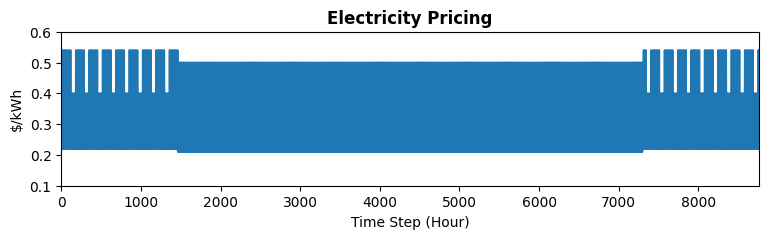

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
x = pricing_data.index
y = pricing_data['electricity_pricing']
ax.plot(x, y)
ax.set_xlabel('Time Step (Hour)')
ax.set_ylabel('$/kWh')
plt.title('Electricity Pricing', fontweight='bold')
plt.ylim(0.1,0.6)
plt.savefig('preview_plots/pricing', bbox_inches = 'tight')
plt.show()

### Preview Carbon Intensity Data

Another supplementary data in the `citylearn_challenge_2022_phase_all` dataset is the grid carbon intensity time series descring the CO<sub>2</sub> equivalent of greenhouse gases that are emitted for every unit kWh of energy consumption. This carbon intensity data were provided by EPRI and the time series is shown with its summary statistics below:

In [12]:
filename = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(root_directory, filename)
carbon_intensity_data = pd.read_csv(filepath)
display(carbon_intensity_data.head())
display(carbon_intensity_data.describe(include='all').T)

,carbon_intensity
0,0.170724
1,0.157319
2,0.154503
3,0.150945
4,0.151820


,count,mean,std,min,25%,50%,75%,max
carbon_intensity,8760.0,0.156531,0.03537,0.070383,0.13108,0.154263,0.178429,0.281796


We also preview the carbon intensity time series on a pair of axes:

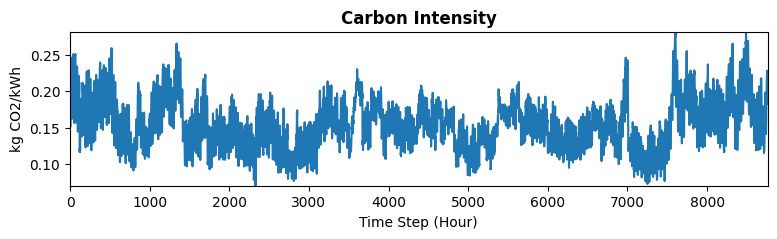

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
x = carbon_intensity_data.index
y = carbon_intensity_data['carbon_intensity']
ax.plot(x, y)
ax.set_xlabel('Time Step (Hour)')
ax.set_ylabel('kg CO2/kWh')
plt.title('Carbon Intensity', fontweight='bold')
plt.savefig('preview_plots/carbon', bbox_inches = 'tight')
plt.show()

# Key Performance Indicators for Evaluation
---

We evaluate the control agents' performance using six key performance indicators (KPIs) that are to be minimized: electricity consumption, cost, carbon emissions, average daily peak, ramping, and (1 - load factor). average daily peak, ramping and (1 - load factor) are district-level KPIs that are calculated using the aggregated district-level hourly net electricity consumption (kWh), $E_h^{\textrm{district}}$. electricity consumption, cost, and carbon emissions are building-level KPIs that are calculated using the building-level hourly net electricity consumption (kWh), $E_h^{\textrm{building}}$, and are reported at the grid level as the average of the building-level values.

Electricity consumption is defined as the sum of imported electricity $E_h^{\textrm{building}}$ as the objective is to minimize the energy consumed but not profit from the excess generation.

$$
    \textrm{electricity consumption} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \right)}
$$

Cost is defined as the sum of building-level imported electricity cost, $E_h^{\textrm{building}} \times T_h$ (\$), where $T_h$ is the electricity rate at hour $h$.

$$
    \textrm{cost} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times T_h \right )}
$$

Carbon emissions is the sum of building-level carbon emissions (kg<sub>CO<sub>2</sub>e</sub>), $E_h^{\textrm{building}} \times O_h$, where $O_h$ is the carbon intensity (kg<sub>CO<sub>2</sub>e</sub>/kWh) at hour $h$.

$$
    \textrm{carbon emissions} = \sum_{h=0}^{n-1}{\textrm{max} \left (0,E_h^{\textrm{building}} \times O_h \right )}
$$

Average daily peak, is defined as the mean of the daily $E_h^{\textrm{district}}$ peak where $d$ is the day index and $n$ is the total number of days.

$$
    \textrm{average daily peak} = \frac{
        {\sum}_{d=0}^{n - 1} {\sum}_{h=0}^{23} {\textrm{max} \left (E_{24d + h}^{\textrm{district}}, \dots, E_{24d + 23}^{\textrm{district}} \right)}
    }{n}
$$

Ramping is defined as the absolute difference of consecutive $E_h^{\textrm{district}}$. It represents the smoothness of the district’s load profile where low ramping means there is gradual increase in grid load even after self-generation becomes unavailable in the evening and early morning. High ramping means abrupt change in grid load that may lead to unscheduled strain on grid infrastructure and blackouts as a result of supply deficit.

$$
    \textrm{ramping} = \sum_{h=0}^{n-1}  \lvert E_{h}^{\textrm{district}} - E_{h - 1}^{\textrm{district}} \rvert
$$

Load factor is defined as the average ratio of monthly average and peak $E_{h}^{\textrm{district}}$ where $m$ is the month index, $d$ is the number of days in a month and $n$ is the number of months. load factor represents the efficiency of electricity consumption and is bounded between 0 (very inefficient) and 1 (highly efficient) thus, the goal is to maximize the load factor or in the same fashion as the other KPIs, minimize (1 - load factor).

$$
    \textrm{1 - load factor}  = \Big(
        \sum_{m=0}^{n - 1} 1 - \frac{
            \left (
                \sum_{h=0}^{d - 1} E_{d \cdot m + h}^{\textrm{district}}
            \right ) \div d
        }{
            \textrm{max} \left (E_{d \cdot m}^{\textrm{district}}, \dots, E_{d \cdot m + d - 1}^{\textrm{district}} \right )
    }\Big) \div n
$$

For the remainder of the paper, the KPIs are reported as normalized values with respect to the baseline outcome where the baseline outcome is when buildings are not equipped with batteries i.e., no control.

$$
    \textrm{KPI} = \frac{{\textrm{KPI}_{control}}}{\textrm{KPI}_{baseline (no\ battery)}}
$$